# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

import os

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

# Data

In [3]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

# Y_train_8 = pd.read_csv('Data/Y_train_8.csv', header=None, delimiter=',').values
# Y_test_8 = pd.read_csv('Data/Y_test_8.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [4]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# train_y_8 = torch.tensor(Y_train_8, dtype=torch.float32)
# test_y_8 = torch.tensor(Y_test_8, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)

## PCA of output

In [5]:
pca_20 = PCA(n_components = 20)

pca_20.fit(train_y[:,1:])
torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
torch.set_num_interop_threads(4)

# Emulators

In [6]:
Device = 'cpu'

In [7]:
row_idx = 0

input_point = test_y[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = 100)

bounds = bound.get_bounds(local_train_x)

## Training part

### LocalGP

In [ ]:
output_file = 'Result/LocalGP_21_result.csv'


if not os.path.exists(output_file):
    with open(output_file, 'w') as f:
        f.write('Iteration,test_preds,estimated_params,posterior_means\n')



In [ ]:
row_idx = 0


input_point = test_y_21[row_idx, :]

local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k=100)

LocalGP_models, LocalGP_likelihoods = Training.train_one_row_LocalGP_Parallel(
    train_x, train_y_21, test_y_21, row_idx,
    covar_type='RBF', k_num=100, lr=0.025,
    num_iterations=5000, patience=10, device=Device
)


In [ ]:
preds_tmp = Prediction.full_preds(
    LocalGP_models, LocalGP_likelihoods, test_x[row_idx, :].unsqueeze(0).to(Device)
).cpu().detach().numpy()



estimated_params_tmp, _ = Estimation.multi_start_estimation(
    LocalGP_models, LocalGP_likelihoods, row_idx, test_y_21, bounds,
    Estimation.estimate_params_Adam, num_starts=5, num_iterations=2000, lr=0.01,
    patience=50, attraction_threshold=0.1, repulsion_strength=0.1, device=Device
)




In [ ]:
bounds = bound.get_bounds(local_train_x)
params = []

for i, (min_val, max_val) in enumerate(bounds):
    param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
    params.append(param_i)

theta = torch.stack(params)

In [ ]:
bounds

In [ ]:
bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]

In [ ]:
params = []
for i, (min_val, max_val) in enumerate(bounds):
    param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
    params.append(param_i)

theta = torch.stack(params)

In [ ]:
with pyro.plate("params", len(bounds)):
    min_vals = torch.tensor([b[0].item() for b in bounds], dtype=torch.float32)
    max_vals = torch.tensor([b[1].item() for b in bounds], dtype=torch.float32)
    params = pyro.sample("params", dist.Uniform(min_vals, max_vals).to_event(1))
    print(f"Sampled params: {params}")

theta = params

In [ ]:
params = []
with pyro.plate("params", len(bounds)):
    for i, (min_val, max_val) in enumerate(bounds):
        param_i = pyro.sample(f"param_{i}", dist.Uniform(min_val, max_val))
        params.append(param_i)
theta = torch.stack(params)

In [ ]:
theta

In [ ]:
theta

In [ ]:
PCA_func = pca_20
num_sampling=200
warmup_step=100
num_chains=1



bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]

if PCA_func != 'None':
    components = torch.from_numpy(PCA_func.components_).to(dtype=torch.float32)
    mean_PCA = torch.from_numpy(PCA_func.mean_).to(dtype=torch.float32)

@torch.compile
def model():

    params = []
    for i, (min_val, max_val) in enumerate(bounds):
        param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
        params.append(param_i)
    
    theta = torch.stack(params)

    sigma = pyro.sample('sigma', dist.HalfNormal(10.0))

    if PCA_func == 'None':
        mu_value = Prediction.full_preds(LocalGP_models, LocalGP_likelihoods, theta.unsqueeze(0)).view(-1)
    else:
        preds = Prediction.full_preds(LocalGP_models, LocalGP_likelihoods, theta.unsqueeze(0))
        first_col = preds[0].view(-1)
        remaining_cols = preds[1:].view(-1)
        processed_cols = (torch.matmul(remaining_cols, components) + mean_PCA)
        mu_value = torch.cat([first_col.unsqueeze(1), processed_cols.unsqueeze(0)], dim=1).view(-1)

    y_obs = test_y[row_idx, :]
    pyro.sample('obs', dist.Normal(mu_value, sigma), obs=y_obs)

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
mcmc.run()


In [ ]:
torch._dynamo.config.verbose = True
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(
    Prediction.full_preds, LocalGP_models, LocalGP_likelihoods, 
    row_idx, test_y, bounds, 
    PCA_func=pca_20, 
    num_sampling=400, warmup_step=100, num_chains=1
)
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

param_names = [f'param_{i}' for i in range(len(bounds))]
posterior_means_array_tmp = np.zeros(len(param_names))

for idx, param_name in enumerate(param_names):
    samples = posterior_samples_Uniform[param_name]
    if samples.ndim > 1:
        samples = samples.reshape(-1)
    posterior_means_array_tmp[idx] = torch.mean(samples).item()




In [ ]:
print(posterior_samples_Uniform)

In [ ]:
with open(output_file, 'a') as f:
    f.write(f"{row_idx + 1},\"{list(preds_tmp)}\",\"{list(estimated_params_tmp.detach().numpy())}\",\"{list(posterior_means_array_tmp)}\"\n")

In [ ]:
def train_and_predict_LocalGP(row_idx, train_x, train_y, test_x, test_y, K_num = 100, Device = 'cpu', PCA_trans = 'None'):

    LocalGP_models, LocalGP_likelihoods = Training.train_one_row_LocalGP(
        train_x, train_y, test_y, row_idx, covar_type = 'RQ', k_num=K_num, lr=0.05, num_iterations=5000, patience=10, device=Device
    )
    
    preds = Prediction.full_preds(LocalGP_models, LocalGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).cpu().detach().numpy()
    if PCA_trans != 'None':
        preds = PCA_trans.inverse_transform(preds)

    return preds




In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_LocalGP)(row_idx, train_x, train_y_20, test_x, test_y_20, PCA_trans = pca_20) for row_idx in range(test_y.shape[0]))
full_test_preds_LocalGP = np.vstack(results)

MSE_LocalGP = np.mean((full_test_preds_LocalGP - test_y.numpy()) ** 2)

In [ ]:
MSE_LocalGP

In [ ]:
MSE_LocalGP

### MultiGP

In [ ]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 100)


MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(local_train_x, local_train_y, n_tasks = local_train_y.shape[1], 
                                                                                 covar_type = 'RBF', lr=0.05, num_iterations=5000, patience=10, device=Device)


In [ ]:
Prediction.preds_for_one_model(MultitaskGP_models, MultitaskGP_likelihoods, theta.unsqueeze(0)).view(-1)

In [ ]:
def train_and_predict_MGP(row_idx, train_x, train_y, test_x, test_y, K_num = 100, Device = 'cpu', PCA_trans = 'None'):


    input_point = test_y[row_idx,:]
    local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = K_num)

    MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_MultitaskGP(local_train_x, local_train_y, n_tasks = train_y.shape[1], covar_type = 'RQ', 
                                                                                     lr=0.05, num_iterations=10000, patience=10, device=Device)

    preds = Prediction.preds_for_one_model(MultitaskGP_models, MultitaskGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).detach().numpy()
    if PCA_trans != 'None':
        preds = PCA_trans.inverse_transform(preds)

    return preds



In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_MGP)(row_idx, train_x, train_y, test_x, test_y) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


np.mean((full_test_preds_MGP - test_y.numpy()) ** 2)

### NN + MultiGP

In [ ]:
row_idx = 0

input_point = test_y[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = 100)

MultitaskGP_models, MultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(local_train_x, local_train_y, n_tasks = train_y.shape[1], 
                                                                                   feature_extractor_class = FeatureE.FeatureExtractor_1, covar_type = 'RBF', 
                                                                                   lr=0.05, num_iterations=5000, patience=10, device = Device)
    

In [ ]:
def train_and_predict_NNMGP(row_idx, train_x, train_y, test_x, test_y, K_num = 100, Device = 'cpu', PCA_trans = 'None'):


    input_point = test_y[row_idx,:]
    local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = K_num)

    NNMultitaskGP_models, NNMultitaskGP_likelihoods = Training.train_one_row_NNMultitaskGP(local_train_x, local_train_y, n_tasks = train_y.shape[1], 
                                                                                            feature_extractor_class = FeatureE.FeatureExtractor_4, covar_type = 'RBF', 
                                                                                            lr=0.05, num_iterations=5000, patience=10, device = Device)

    preds = Prediction.preds_for_one_model(NNMultitaskGP_models, NNMultitaskGP_likelihoods, test_x[row_idx,:].unsqueeze(0).to(Device)).squeeze().detach().numpy()
    if PCA_trans != 'None':
        # preds = PCA_trans.inverse_transform(preds)
        first_column = preds[0]
        remaining_columns = preds[1:]
        remaining_columns = PCA_trans.inverse_transform(remaining_columns)
        preds = np.concatenate((first_column, remaining_columns), axis=1)

    return preds



In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y, test_x, test_y) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


MSE_NNMGP = np.mean((full_test_preds_MGP - test_y.numpy()) ** 2)

In [ ]:
results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y_21, test_x, test_y_21, PCA_trans = pca_20) for row_idx in range(test_y.shape[0]))
# results = Parallel(n_jobs=-1)(delayed(train_and_predict_NNMGP)(row_idx, train_x, train_y_21, test_x, test_y_21) for row_idx in range(test_y.shape[0]))
full_test_preds_MGP = np.vstack(results)


MSE_NNMGP_20 = np.mean((full_test_preds_MGP - test_y_21.numpy()) ** 2)
MSE_NNMGP_20

In [ ]:
MSE_NNMGP_20

### VGP

In [ ]:
inducing_points = train_x[:600, :].to(Device)
VGP_models, VGP_likelihoods = Training.train_full_VGP_Parallel(train_x, train_y_21, inducing_points, covar_type = 'RQ', lr=0.025, num_iterations=5000, patience=30, device=Device)


### MVGP

In [8]:
MVGP_models, MVGP_likelihoods = Training.train_full_MultitaskVGP(train_x, train_y_21, 
                                                                 num_latents=12, num_inducing=100, 
                                                                 lr_hyper=0.05, lr_variational=0.05, num_iterations=5000, patience=50, device=Device)


 39%|███▉      | 1955/5000 [05:07<07:59,  6.35it/s, loss=-16.8] 


In [9]:
full_test_preds_MVGP = Prediction.preds_for_one_model(MVGP_models, MVGP_likelihoods, test_x.to(Device)).cpu().detach().numpy()
np.mean((full_test_preds_MVGP.reshape(120,21) - test_y_21.numpy()) ** 2)

0.010462959

In [ ]:
full_test_preds_MVGP = pca_20.inverse_transform(full_test_preds_MVGP)
MSE_MVGP = np.mean((full_test_preds_MVGP - test_y.numpy()) ** 2)
MSE_MVGP

### DGP

In [ ]:
# Device = 'cuda'
DGP_2 = Training.train_full_DGP_2(train_x, train_y, num_hidden_dgp_dims = 10, inducing_num = 100, num_iterations = 5000, patiences = 50, device=Device)

# Estimation

### Point estimation

In [ ]:
estimated_params, func_loss = Estimation.multi_start_estimation(MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y, bounds, Estimation.estimate_params_for_one_model_Adam, 
                                                                num_starts=5, num_iterations=2000, lr=0.01, patience=10, 
                                                                attraction_threshold=0.1, repulsion_strength=0.1, device=Device)


# full_estimated_params = estimated_params.detach().numpy()


In [ ]:
estimated_params

### MCMC 

In [25]:
mcmc_result_Uniform = Estimation.run_mcmc_Uniform(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds, 
                                                  num_sampling = 1200, warmup_step = 300)



Sample: 100%|██████████| 1500/1500 [17:19,  1.44it/s, step size=1.42e-01, acc. prob=0.941]


In [ ]:
mcmc_result_Normal = Estimation.run_mcmc_Normal(Prediction.preds_for_one_model, MultitaskGP_models, MultitaskGP_likelihoods, row_idx, test_y, local_train_x, 
                                                 PCA_func = pca_20, 
                                                 num_sampling = 400, warmup_step = 100)



In [26]:
posterior_samples = mcmc_result_Uniform.get_samples()

param_names = [f'param_{i}' for i in range(len(bounds))]

posterior_means_array = np.zeros(len(param_names))


for idx, param_name in enumerate(param_names):
    samples = posterior_samples[param_name]
    if samples.ndim > 1:
        samples = samples.reshape(-1)
    mean_value = torch.mean(samples).item()
    posterior_means_array[idx] = mean_value

### Plot

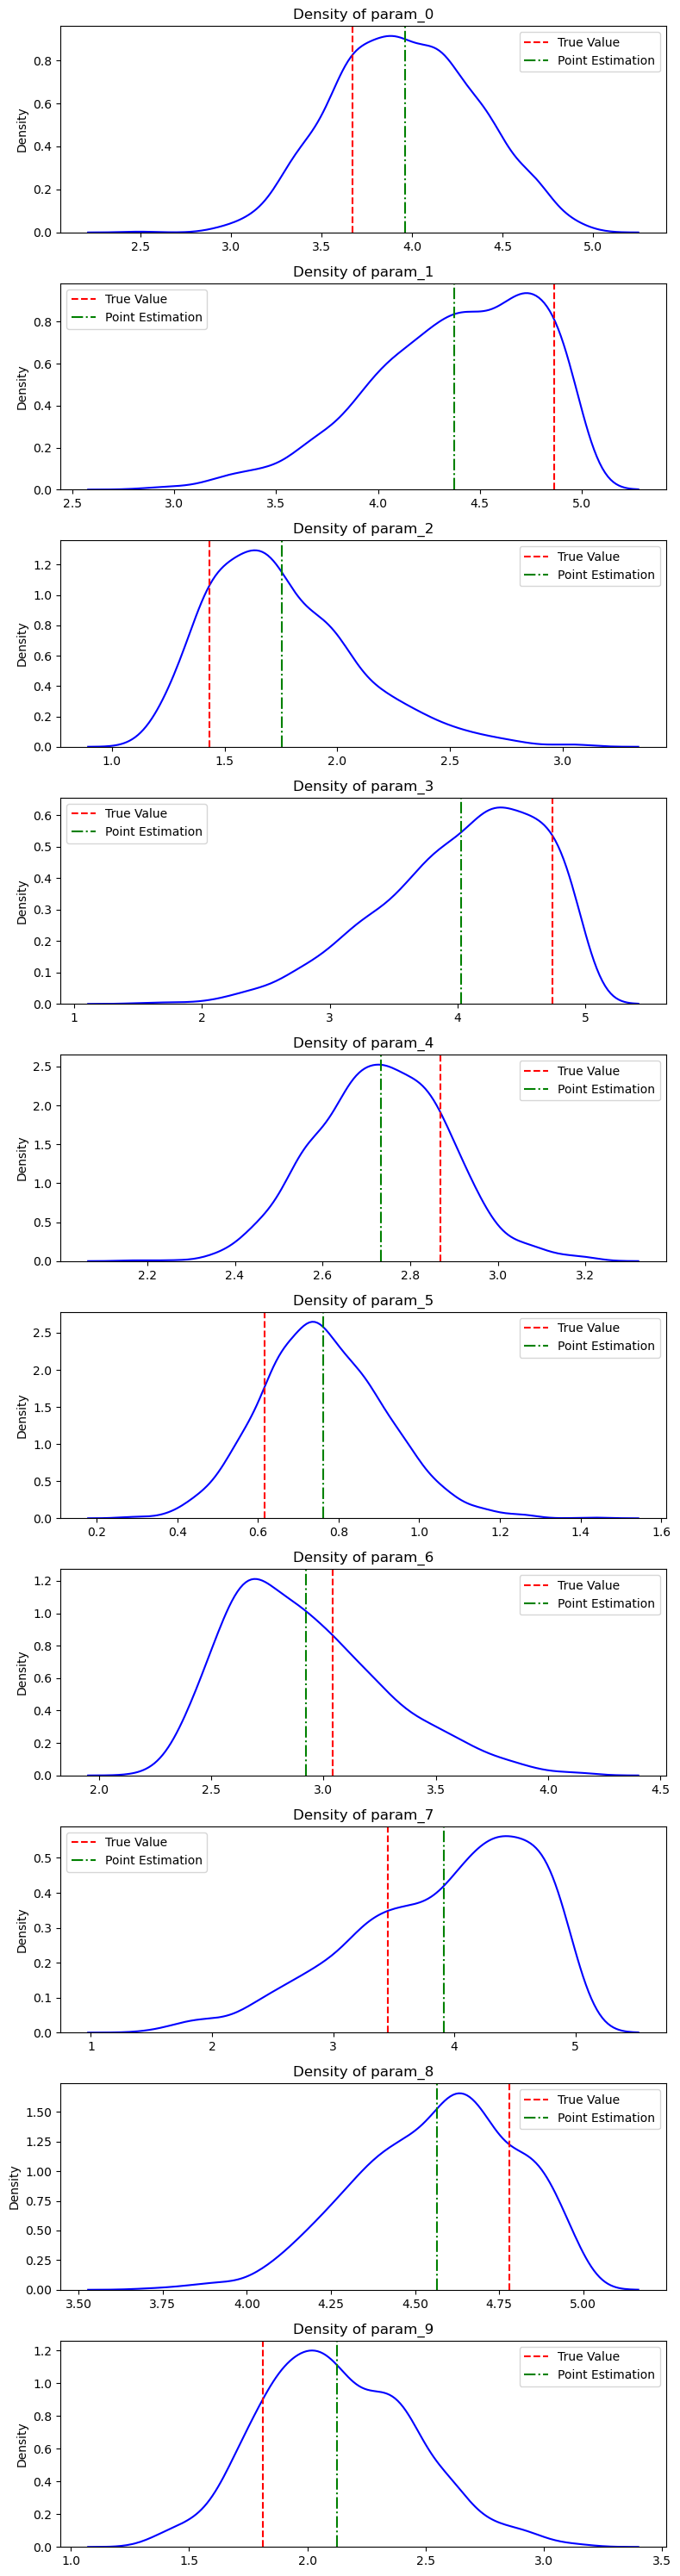

In [ ]:
posterior_samples_Uniform = mcmc_result_Uniform.get_samples()

true_values = test_x[row_idx,:]

point_estimations = posterior_means_array

fig, axes = plt.subplots(len(posterior_samples_Uniform), 1, figsize=(8, len(posterior_samples_Uniform) * 3))

for i, (param_name, samples) in enumerate(posterior_samples_Uniform.items()):
    if len(posterior_samples_Uniform) > 1:
        ax = axes[i]
    else:
        ax = axes
    sns.kdeplot(samples.detach().numpy(), ax=ax, color='blue')ccc   
    ax.set_title(f'Density of {param_name}')
    
    # 标记 true_values 和 point_estimations
    if true_values is not None and i < len(true_values):
        ax.axvline(true_values[i], color='red', linestyle='--', label='True Value')
    if point_estimations is not None and i < len(point_estimations):
        ax.axvline(point_estimations[i], color='green', linestyle='-.', label='Point Estimation')
    ax.legend()

plt.tight_layout()
plt.show()

In [30]:
posterior_samples_Uniform

{'param_0': tensor([3.3919, 3.7494, 3.9608,  ..., 3.5816, 3.6459, 4.3290]),
 'param_1': tensor([4.6662, 4.6069, 4.7131,  ..., 4.7354, 4.8199, 4.6352]),
 'param_2': tensor([1.8728, 2.1679, 2.0178,  ..., 1.4547, 1.3130, 1.7461]),
 'param_3': tensor([3.8932, 3.3993, 3.3307,  ..., 4.6739, 4.6768, 4.1510]),
 'param_4': tensor([2.5470, 2.6259, 2.7000,  ..., 2.8141, 2.7455, 2.8051]),
 'param_5': tensor([0.8762, 0.7099, 0.9146,  ..., 0.8322, 0.6688, 0.5246]),
 'param_6': tensor([2.8707, 3.0986, 3.1980,  ..., 2.6280, 3.2726, 2.6299]),
 'param_7': tensor([3.9046, 3.3485, 3.4988,  ..., 3.9589, 3.3874, 4.1045]),
 'param_8': tensor([4.1528, 4.8810, 4.7665,  ..., 4.6257, 4.4287, 4.2391]),
 'param_9': tensor([2.4036, 1.8237, 1.8287,  ..., 1.8415, 2.1645, 2.0195])}

In [31]:
posterior_samples_Uniform['param_1']

tensor([4.6662, 4.6069, 4.7131,  ..., 4.7354, 4.8199, 4.6352])

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


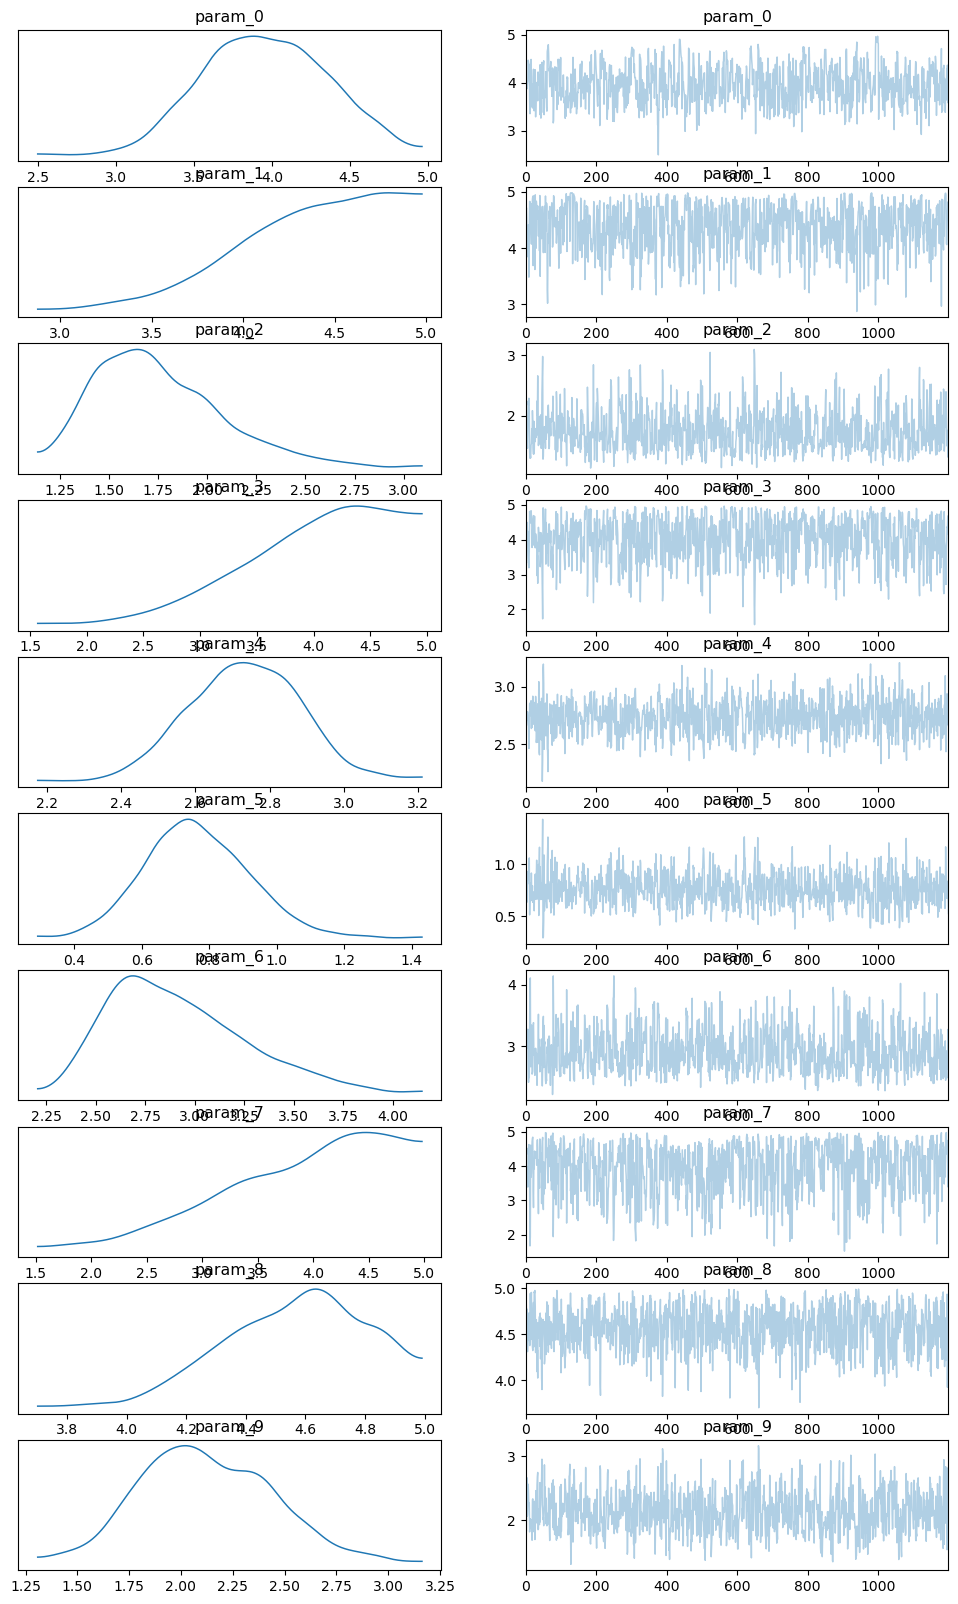

arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  3.962  0.390     3.251      4.697      0.019    0.014     418.0   
param_1  4.374  0.411     3.622      4.979      0.017    0.012     454.0   
param_2  1.753  0.329     1.198      2.397      0.013    0.009     604.0   
param_3  4.030  0.627     2.854      4.958      0.026    0.019     540.0   
param_4  2.734  0.150     2.426      2.995      0.005    0.004     755.0   
param_5  0.763  0.153     0.487      1.083      0.006    0.004     768.0   
param_6  2.920  0.349     2.346      3.618      0.014    0.010     615.0   
param_7  3.916  0.739     2.538      4.982      0.032    0.023     503.0   
param_8  4.565  0.236     4.153      4.993      0.008    0.006     696.0   
param_9  2.127  0.322     1.544      2.792      0.013    0.009     590.0   

         ess_tail  r_hat  
param_0     361.0    NaN  
param_1     429.0    NaN  
param_2     800.0    NaN  
param_3     519.0    NaN  
param_4     824.0    NaN  
p

In [29]:
idata = az.from_pyro(mcmc_result_Uniform)
az.plot_trace(idata)
plt.show()


summary = az.summary(idata, hdi_prob=0.95)
print(summary)

# **End**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Gaussian distribution
mu = 0  # mean
sigma = 1  # standard deviation

# Generate random samples from the Gaussian distribution
x = np.random.normal(mu, sigma, 10000)
# x = np.random.uniform(mu, sigma, 10000)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(x, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')


# Labeling the plot

plt.xlabel("X values")
plt.ylabel("Probability Density")

plt.show()


In [ ]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the affine transformation function
def affine_transform(x, loc=1.3, scale=2.6):
    return loc + scale * x

In [ ]:
# Apply sigmoid transform to the generated data
# x_1 = affine_transform(x,3,1.5)
x_2 = sigmoid(x)
x_transformed = affine_transform(x_2)

# Plot the transformed distribution
plt.figure(figsize=(8, 6))
plt.hist(x_transformed, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Labeling the plot
plt.xlabel("Transformed X values")
plt.ylabel("Probability Density")

plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

row_idx = 0

input_point = test_y[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y, k = 400)

# 假设x是已知数据
x = local_train_x[:,3] 

# 1. 绘制直方图
plt.hist(x, bins=30, density=True, alpha=0.6, color='g')

# 2. 尝试拟合正态分布
mu, std = stats.norm.fit(x)

# 3. 绘制拟合的正态分布曲线
xmin, xmax = plt.xlim()
x_plot = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x_plot, mu, std)
plt.plot(x_plot, p, 'k', linewidth=2)
title = f"Fit results: mu = {mu:.2f}, std = {std:.2f}"
plt.title(title)
plt.show()

# 4. 生成与数据类似的随机数
random_data = np.random.normal(mu, std, len(x))


In [ ]:
test_x[0,:]